In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# producing input data for fitness estimator
Case with 3 mutable strains. Compare simulated cell numbers to fitseq estimates. 

## Imports

In [3]:
import multiprocess as mp
import os, shutil, numpy
from matplotlib import pyplot
import math

In [4]:
from GillespieSimulator.GillespieEngine import GillespieEngine
from GillespieSimulator.Parameters import Parameters

In [5]:
from GillespieSimulator.analysis import *

In [6]:
number_of_cpus = mp.cpu_count()
print("There are {} CPUs on this system.".format(number_of_cpus))

There are 48 CPUs on this system.


## Setup the parameters 

In [177]:
parameters = Parameters(max_time=10,
         max_population_size=None,
         division_rate=1.0,
         division_rate_fwhm=0.0,
         mutation_probability=0.1,
         death_rate=0.0,
         death_rate_fwhm=0.0,
         pdf_mean=0.02,
         pdf_rms=.01,
         barcode_size=0,
         genome_size=1,
         carrying_capacity=10000,
         theta=0,
        )
         

### Simulation output

In [18]:
output_dir = 'fitness_CM'
output_dir = os.path.join("/home/grotec/Projects/gillespiesimulator/notebooks", output_dir)

In [179]:
def run_engine(run_number):
    # print("Setting seed")
    seed = run_number
    numpy.random.seed(seed)
    
    # print("Setting up engine.")
    engine = GillespieEngine(parameters=parameters,
                             population=[10, 10, 10],
                             outdir=os.path.join(output_dir,'gillespie_run_out_{0:04d}'.format(run_number))
                            )  
    
    # print("Running the engine")
    engine.run(snapshot_interval=1)
    
    print("Simulation data was written to {}.".format(engine.outdir))

### Determine number of processes available to this run.

### Set number of runs 

In [25]:
number_of_runs = 24
runs = range(number_of_runs)

if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

## Setup the process pool

### Set the number of cpus to use in this run.
This number should be equal or less to the number of simulations to run to avoid idling processes. It's ok to oversubscribe the CPU that is to make a pool that has more processes than there are CPU cores.

In [14]:
pool_size = min(number_of_runs, number_of_cpus); pool_size

24

# Run the pool of simulations in parallel.
with mp.Pool(pool_size) as pool:

### We use the `imap_unordered` method of `Pool` to take advantage of the `chunksize` parameter, which in the case of many long runs reduces the memory consumption. 
    pool.imap_unordered(run_engine, runs, chunksize=1)
    pool.close()
    pool.join()

## Visualize results

In [14]:
runs = load_runs([os.path.join(output_dir,d) for d in os.listdir(output_dir)])

In [15]:
display(interactive_plot_widget(runs))

### Filter out those runs with 3 surviving lineages 

In [16]:
# Make dictionary {run: mutant} from output data.
all_mutants = dict([(run, mutants(runs[run])) for run in runs.keys()])

In [17]:
for k,v in all_mutants.items():
    #v.columns = v.columns.droplevel('Mutant ID')
    v.index = range(len(v.index))
    lineages = v.groupby(level='Barcode ID', axis='columns').sum() # Pool barcode IDs.
    lineages.T.to_csv(os.path.join(output_dir,'run_{}.csv'.format(k)), index=False)

In [18]:
!python pyfitseq.py -i fitness_CM/run_0.csv -t 0 1 2 3 4 5 6 7 8 9 10 -o fitness_CM/run_0

Iteration 1: -96.67026420751496
Iteration 2: -95.49212089399074
Iteration 3: -95.48553674001315


In [19]:
estimates = pandas.read_csv(os.path.join(output_dir,'run_0_FitSeq.csv'))

In [20]:
estimates

Estimated_Fitness  Likelihood_Log  Estimated_Mean_Fitness  \
0            0.424379      -17.803498                0.000000   
1            0.334746      -38.717666                0.089345   
2            0.025894      -22.251221                0.079043   
3           -0.403078      -16.594985                0.162177   
4                 NaN             NaN                0.271821   
5                 NaN             NaN                0.310251   
6                 NaN             NaN                0.318604   
7                 NaN             NaN                0.328880   
8                 NaN             NaN                0.334507   
9                 NaN             NaN                0.335653   
10                NaN             NaN                0.343943   

    Estimated_Read_Number_t0  Estimated_Read_Number_t1  \
0                        1.0                       2.0   
1                       10.0                      21.0   
2                       10.0                      15.0   
3                       10.0                      10.0   
4                        NaN                       NaN   
5                        NaN                       NaN   
6                        NaN                       NaN   
7                        NaN                       NaN   
8                        NaN                       NaN   
9                        NaN                       NaN   
10                       NaN                       NaN   

    Estimated_Read_Number_t2  Estimated_Read_Number_t3  \
0                        1.0                       3.0   
1                       25.0                      45.0   
2                       23.0                      15.0   
3                       12.0                      11.0   
4                        NaN                       NaN   
5                        NaN                       NaN   
6                        NaN                       NaN   
7                        NaN                       NaN   
8                        NaN                       NaN   
9                        NaN                       NaN   
10                       NaN                       NaN   

    Estimated_Read_Number_t4  Estimated_Read_Number_t5  \
0                        3.0                       5.0   
1                       66.0                      91.0   
2                       17.0                       9.0   
3                        0.0                       0.0   
4                        NaN                       NaN   
5                        NaN                       NaN   
6                        NaN                       NaN   
7                        NaN                       NaN   
8                        NaN                       NaN   
9                        NaN                       NaN   
10                       NaN                       NaN   

    Estimated_Read_Number_t6  Estimated_Read_Number_t7  \
0                        5.0                       6.0   
1                       90.0                      97.0   
2                        6.0                       3.0   
3                        0.0                       0.0   
4                        NaN                       NaN   
5                        NaN                       NaN   
6                        NaN                       NaN   
7                        NaN                       NaN   
8                        NaN                       NaN   
9                        NaN                       NaN   
10                       NaN                       NaN   

    Estimated_Read_Number_t8  Estimated_Read_Number_t9  \
0                        6.0                       8.0   
1                       89.0                      83.0   
2                        2.0                       2.0   
3                        0.0                       0.0   
4                        NaN                       NaN   
5                        NaN                       NaN   
6                        NaN 

In [21]:
estimated_cell_counts = estimates.T.loc["Estimated_Read_Number_t0":,1:3]

In [22]:
estimated_cell_counts.index = [idx.split('t')[-1] for idx in estimated_cell_counts.index]

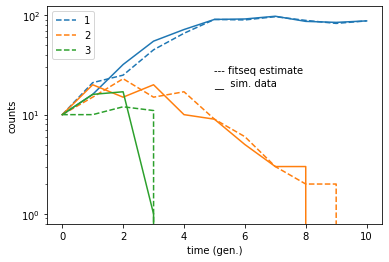

In [23]:
fig, ax = pyplot.subplots()
lines = estimated_cell_counts.plot(logy=True, ax=ax, style='--')
colors = [l.get_color() for l in lines.lines]
all_mutants[0].groupby(level='Barcode ID', axis='columns').sum().plot(logy=True, ax=ax, color=colors, legend=False)
_ = ax.set_xlabel("time (gen.)")
_ = ax.set_ylabel("counts")
_ = ax.text(5, 20, "--- fitseq estimate\n__  sim. data")

# 100 lineages 

## Setup the parameters 

In [24]:
parameters = Parameters(
         max_time=10,
         max_population_size=None,
         division_rate=1.0,
         division_rate_fwhm=0.0,
         mutation_probability=0.01,
         death_rate=0.0,
         death_rate_fwhm=0.0,
         pdf_mean=0.0002,
         pdf_rms=.01,
         barcode_size=0,
         genome_size=1,
         carrying_capacity=1000000,
         theta=0,
        )
         

### Simulation output

In [25]:
output_dir = 'fitness_CM_100lineages'

In [26]:
def run_engine(run_number):
    # print("Setting seed")
    seed = run_number
    numpy.random.seed(seed)
    
    # print("Setting up engine.")
    engine = GillespieEngine(parameters=parameters,
                             population=[10]*100,
                             outdir=os.path.join(output_dir,'gillespie_run_out_{0:04d}'.format(run_number))
                            )  
    
    # print("Running the engine")
    engine.run(snapshot_interval=1)
    
    print("Simulation data was written to {}.".format(engine.outdir))

### Determine number of processes available to this run.

In [27]:
number_of_runs = 24
runs = range(number_of_runs)

if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

## Setup the process pool

### Set the number of cpus to use in this run.
This number should be equal or less to the number of simulations to run to avoid idling processes. It's ok to oversubscribe the CPU that is to make a pool that has more processes than there are CPU cores.

In [29]:
pool_size = min(number_of_runs, number_of_cpus); pool_size

24

# Run the pool of simulations in parallel.
with mp.Pool(pool_size) as pool:

### We use the `imap_unordered` method of `Pool` to take advantage of the `chunksize` parameter, which in the case of many long runs reduces the memory consumption. 
    pool.imap_unordered(run_engine, runs, chunksize=1)
    pool.close()
    pool.join()

## Visualize results

In [33]:
runs = load_runs([os.path.join(output_dir,d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir,d))])

In [34]:
display(interactive_plot_widget(runs))

### Filter out those runs with 3 surviving lineages 

In [37]:
# Make dictionary {run: mutant} from output data.
all_mutants = dict([(run, mutants(runs[run])) for run in runs.keys()])

In [38]:
for k,v in all_mutants.items():
    #v.columns = v.columns.droplevel('Mutant ID')
    v.index = range(len(v.index))
    lineages = v.groupby(level='Barcode ID', axis='columns').sum() # Pool barcode IDs.
    lineages.T.to_csv(os.path.join(output_dir,'run_{}.csv'.format(k)), index=False)

In [39]:
!python pyfitseq.py -i fitness_CM_100lineages/run_0.csv -t 0 1 2 3 4 5 6 7 8 9 10 -o fitness_CM_100lineages/run_0

Iteration 1: -1272.1988015323595
Iteration 2: -1261.0238178165557
Iteration 3: -1260.5233705677185
Iteration 4: -1260.7980721146537


In [40]:
estimates = pandas.read_csv(os.path.join(output_dir,'run_0_FitSeq.csv'))

In [41]:
estimates

Estimated_Fitness  Likelihood_Log  Estimated_Mean_Fitness  \
0             0.448498      -17.490674                0.000000   
1            -0.613817       -5.814248                0.012235   
2             0.379270       -8.380798                0.068878   
3            -0.163644       -9.681026                0.119624   
4            -0.613817       -6.730538                0.202552   
..                 ...             ...                     ...   
96            0.046023      -14.562765                     NaN   
97            0.189333      -26.766543                     NaN   
98            0.827796      -39.521202                     NaN   
99            0.379270       -8.380798                     NaN   
100           0.382328       -6.552656                     NaN   

     Estimated_Read_Number_t0  Estimated_Read_Number_t1  \
0                           1                         0   
1                          10                         5   
2                          10                         5   
3                          10                         5   
4                          10                         5   
..                        ...                       ...   
96                         10                         5   
97                         10                         5   
98                         10                         6   
99                         10                         5   
100                        10                         5   

     Estimated_Read_Number_t2  Estimated_Read_Number_t3  \
0                           1                         2   
1                           2                         1   
2                           2                         1   
3                           3                         3   
4                           2                         1   
..                        ...                       ...   
96                          2                         1   
97                          3                         2   
98                          9                         3   
99                          2                         1   
100                         2                         1   

     Estimated_Read_Number_t4  Estimated_Read_Number_t5  \
0                           4                         4   
1                           0                         0   
2                           0                         0   
3                           4                         1   
4                           0                         0   
..                        ...                       ...   
96                          1                         3   
97                          4                         9   
98                          6                        10   
99                          0                         0   
100                         0                         0   

     Estimated_Read_Number_t6  Estimated_Read_Number_t7  \
0                           5                         6   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   
..                        ...                       ...   
96                          2                         1   
97                          5                        11   
98                          9                        11   
99                          0                         0   
100                         0                         0   

     Estimated_Read_Number_t8  Estimated_Read_Number_t9  \
0                           8                        10   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   
..                    

In [42]:
estimated_cell_counts = estimates.T.loc["Estimated_Read_Number_t0":,1:]

In [43]:
estimated_cell_counts.index = [idx.split('t')[-1] for idx in estimated_cell_counts.index]
estimated_cell_counts.columns = [int(col)-1 for col in estimated_cell_counts.columns]

In [24]:
# Sort lineages by frequency at t10
# Plot sim vs. estimate for all lineages in sep. plot.
# big question: what is the relation of fitness to competition matrix?

In [44]:
# Make dataframes for estimates and simulations
# run 0.
estimated_cell_counts

0     1     2     3     4     5     6     7     8     9   ...    90  \
0   10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  ...  10.0   
1    5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0  ...   5.0   
2    2.0   2.0   3.0   2.0   2.0   5.0  10.0   2.0   2.0   2.0  ...   3.0   
3    1.0   1.0   3.0   1.0   1.0   8.0  10.0   1.0   1.0   1.0  ...   5.0   
4    0.0   0.0   4.0   0.0   0.0   5.0  24.0   0.0   0.0   0.0  ...   7.0   
5    0.0   0.0   1.0   0.0   0.0  10.0  11.0   0.0   0.0   0.0  ...   3.0   
6    0.0   0.0   0.0   0.0   0.0   5.0  18.0   0.0   0.0   0.0  ...   0.0   
7    0.0   0.0   0.0   0.0   0.0   2.0  26.0   0.0   0.0   0.0  ...   0.0   
8    0.0   0.0   0.0   0.0   0.0   0.0  21.0   0.0   0.0   0.0  ...   0.0   
9    0.0   0.0   0.0   0.0   0.0   1.0  29.0   0.0   0.0   0.0  ...   0.0   
10   0.0   0.0   0.0   0.0   0.0   1.0  35.0   0.0   0.0   0.0  ...   0.0   

      91    92    93    94    95    96     97    98    99  
0   10.0  10.0  10.0  10.0  10.0  10.0   10.0  10.0  10.0  
1    5.0   5.0   5.0   5.0   5.0   5.0    6.0   5.0   5.0  
2    2.0   7.0   2.0   2.0   2.0   3.0    9.0   2.0   2.0  
3    1.0  14.0   1.0   2.0   1.0   2.0    3.0   1.0   1.0  
4    0.0  14.0   0.0   9.0   1.0   4.0    6.0   0.0   0.0  
5    0.0  13.0   0.0  14.0   3.0   9.0   10.0   0.0   0.0  
6    0.0  18.0   0.0  13.0   2.0   5.0    9.0   0.0   0.0  
7    0.0   4.0   0.0   7.0   1.0  11.0   11.0   0.0   0.0  
8    0.0   1.0   0.0   5.0   1.0   1.0   12.0   0.0   0.0  
9    0.0   0.0   0.0   4.0   0.0   0.0   56.0   0.0   0.0  
10   0.0   0.0   0.0   0.0   0.0   0.0  103.0   0.0   0.0  

[11 rows x 100 columns]

In [45]:
simulated_cell_counts = all_mutants[0].groupby(level='Barcode ID', axis='columns').sum()

In [46]:
simulated_cell_counts

Barcode ID    0     1     2     3     4     5     6     7     8     9   ...  \
0           10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  ...   
1            4.0   0.0   5.0   4.0   1.0   6.0   8.0   0.0   1.0   0.0  ...   
2            1.0   0.0   5.0   0.0   0.0   8.0   8.0   0.0   1.0   0.0  ...   
3            0.0   0.0   5.0   0.0   0.0   5.0  16.0   0.0   1.0   0.0  ...   
4            0.0   0.0   3.0   0.0   0.0  12.0  10.0   0.0   0.0   0.0  ...   
5            0.0   0.0   0.0   0.0   0.0   7.0  17.0   0.0   0.0   0.0  ...   
6            0.0   0.0   0.0   0.0   0.0   3.0  25.0   0.0   0.0   0.0  ...   
7            0.0   0.0   0.0   0.0   0.0   1.0  18.0   0.0   0.0   0.0  ...   
8            0.0   0.0   0.0   0.0   0.0   2.0  24.0   0.0   0.0   0.0  ...   
9            0.0   0.0   0.0   0.0   0.0   2.0  34.0   0.0   0.0   0.0  ...   
10           0.0   0.0   0.0   0.0   0.0   3.0  26.0   0.0   0.0   0.0  ...   

Barcode ID    90    91    92    93    94    95    96     97    98    99  
0           10.0  10.0  10.0  10.0  10.0  10.0  10.0   10.0  10.0  10.0  
1            5.0   4.0   7.0   0.0   1.0   3.0   3.0    5.0   0.0   2.0  
2            7.0   1.0  13.0   0.0   2.0   1.0   2.0    2.0   0.0   1.0  
3            8.0   0.0  11.0   0.0   8.0   1.0   4.0    3.0   0.0   0.0  
4            5.0   0.0  13.0   0.0  15.0   4.0  10.0    6.0   0.0   0.0  
5            1.0   0.0  20.0   0.0  15.0   3.0   7.0    6.0   0.0   0.0  
6            0.0   0.0   5.0   0.0   9.0   2.0  13.0    7.0   0.0   0.0  
7            0.0   0.0   2.0   0.0   6.0   2.0   2.0    7.0   0.0   0.0  
8            0.0   0.0   0.0   0.0   4.0   0.0   1.0   30.0   0.0   0.0  
9            0.0   0.0   0.0   0.0   0.0   0.0   0.0   66.0   0.0   0.0  
10           0.0   0.0   0.0   0.0   0.0   0.0   0.0  120.0   0.0   0.0  

[11 rows x 100 columns]

In [47]:
# sort by survival rate (cell frequency at last timepoint)
last_freqs = simulated_cell_counts.iloc[-1]

In [48]:
sorted_index = last_freqs.sort_values(ascending=False).index

In [49]:
simulated_sorted = simulated_cell_counts.T.iloc[sorted_index].T

In [50]:
estimated_sorted = estimated_cell_counts.T.iloc[sorted_index].T

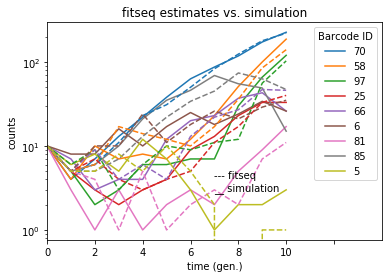

In [51]:
fig, ax = pyplot.subplots()

sim_sub = simulated_sorted.iloc[:,:9].plot(ax=ax, logy=True)
#ax.legend(bbox_to_anchor=[1.05, 1])
colors = [l.get_color() for l in sim_sub.lines]
est_sub = estimated_sorted.iloc[:,:9].plot(ax=ax, style="--", logy=True, color=colors, legend=False)


_ = ax.set_xlabel('time (gen.)')
_ = ax.set_ylabel('counts')
_ = ax.set_title("fitseq estimates vs. simulation")
_ = ax.text(7, 3, "--- fitseq\n__ simulation")
_ = ax.set_xlim([0, 14])



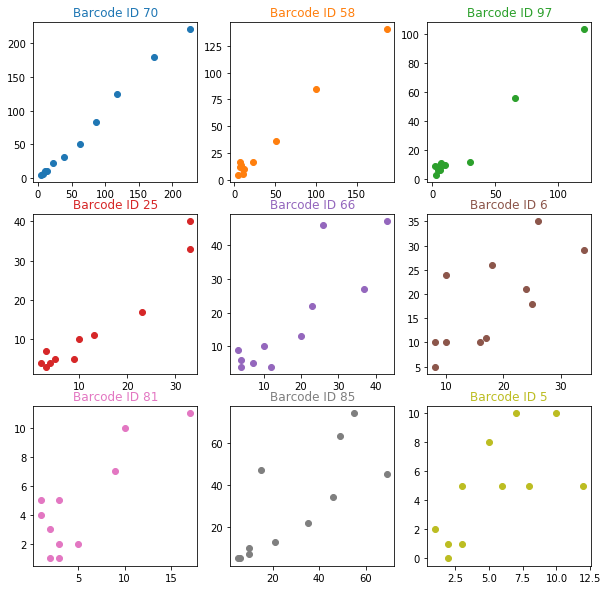

In [52]:
# 3x3 plots correlating sim(i) with est(i)
fig, axs = pyplot.subplots(3,3, figsize=(10,10))

for i in range(9):
    row = i // 3
    col = i % 3
    
    ax = axs[row, col]
    x= simulated_sorted.iloc[:,i]
    y = estimated_sorted.iloc[:,i]

    #ax.scatter(x=x/max(x), y=y/max(y))
    ax.scatter(x=x, y=y, color=colors[i])
    ax.set_title("Barcode ID {}".format(estimated_sorted.columns[i]), color=colors[i])
    #ax.set_xticks([])
    #ax.set_yticks([])

fitseq gives accurate cell count estimates and hence consistent average fitness values for few most prolific lineages. fitseq fails to do so for small cell count numbers. fitseq fails to yield accurate estimates even for prolific lineages if sudden mutations occur, see e.g. Barcode ID 70 (red).

mutation history:

In [53]:
mutations = mutants(runs[0]).groupby(level='Barcode ID', axis=1).count()

In [54]:
mutations.T.iloc[sorted_index].T

Barcode ID          70  58  97  25  66  6   81  85  5   16  ...  60  61  62  \
time (generations)                                          ...               
0.000000             1   1   1   1   1   1   1   1   1   1  ...   1   1   1   
1.001076             1   1   1   1   1   1   1   1   1   1  ...   1   1   1   
2.002256             1   1   2   1   1   1   1   1   1   1  ...   1   1   1   
3.003929             1   1   2   1   1   2   1   1   1   1  ...   1   1   1   
4.003993             1   1   2   1   1   2   1   1   1   1  ...   1   1   1   
5.005867             1   1   2   1   2   2   1   2   1   1  ...   1   1   1   
6.007463             2   1   2   2   2   2   1   2   1   1  ...   1   1   1   
7.011218             2   1   2   2   2   2   1   3   1   1  ...   1   1   1   
8.013719             2   2   2   2   2   2   1   3   1   1  ...   1   1   1   
9.014079             3   2   2   2   2   3   1   3   1   1  ...   1   1   1   
10.000044            6   4   4   3   2   4   1   3   1   1  ...   1   1   1   

Barcode ID          63  64  65  67  68  69  0   
time (generations)                              
0.000000             1   1   1   1   1   1   1  
1.001076             1   1   1   1   1   1   1  
2.002256             1   1   1   1   1   1   1  
3.003929             1   1   1   1   1   1   1  
4.003993             1   1   1   1   1   1   1  
5.005867             1   1   1   1   1   1   1  
6.007463             1   1   1   1   1   1   1  
7.011218             1   1   1   1   1   1   1  
8.013719             1   1   1   1   1   1   1  
9.014079             1   1   1   1   1   1   1  
10.000044            1   1   1   1   1   1   1  

[11 rows x 100 columns]

# Analyse with sliding window 

In [55]:
# try to run fitseq in python

In [56]:
from pyfitseq import main as fitseq

In [57]:
# function to run fitseq on a given slice
def run_fitseq(df):
    """ Run fitseq on the values from passed dataframe. """
    
    values = df.values.T
    times = df.index.values
    
#    return fitseq(values, times, fitness_type='w')
    return fitseq(values, times, fitness_type='m')

In [58]:
sliding_estimates = dict([("{}-{}".format(i, i+2), run_fitseq(simulated_cell_counts[i:i+3])) for i in range(9)])

Iteration 1: -455.99603123490476
Iteration 2: -454.08742109660056
Iteration 3: -453.70887438748935
Iteration 4: -453.6684791618231
Iteration 5: -453.65629001993443
Iteration 6: -453.6521659967027
Iteration 1: -285.27390009312535
Iteration 2: -285.05371874338897
Iteration 3: -284.93498131158685
Iteration 4: -284.8585753145026
Iteration 5: -284.80844598851263
Iteration 6: -284.7751414066818
Iteration 7: -284.75281197968013
Iteration 8: -284.73774293734107
Iteration 9: -284.7275269549541
Iteration 10: -284.72057905501083
Iteration 1: -272.49791681245904
Iteration 2: -272.033771893408
Iteration 3: -271.96682523642824
Iteration 4: -272.0161347450742
Iteration 1: -261.5269089749866
Iteration 2: -261.39812392340417
Iteration 3: -261.3477707760606
Iteration 4: -261.3163248856143
Iteration 5: -261.2962792310862
Iteration 6: -261.2833516886634
Iteration 7: -261.27494743744427
Iteration 1: -243.47389250167578
Iteration 2: -243.5019444156215
Iteration 1: -226.75486028568676
Iteration 2: -226.28378

In [59]:
sliding_fitness = pandas.DataFrame(dict([(k,v["Estimated_Fitness"]) for k, v in sliding_estimates.items()]))

In [60]:
sliding_fitness

0-2       1-3       2-4       3-5       4-6       5-7       6-8  \
0  -0.957159 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   
1   0.035908 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   
2   0.311169  0.541978  0.166211 -0.691457 -0.603457 -0.612243 -0.754365   
3  -0.957159 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   
4   0.035908 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.042043 -0.621713  1.305645  0.807568  0.164062  0.282381 -0.754365   
96  0.042043  0.703426  1.269729  0.628470  0.657854  0.291268 -0.754365   
97 -0.957159 -0.621713  0.996855  0.702131  0.602975  0.619632  1.298925   
98  0.035908 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   
99  0.038976 -0.621713 -0.751561 -0.691457 -0.603457 -0.612243 -0.754365   

         7-9      8-10  
0  -0.847282 -0.802985  
1  -0.847282 -0.802985  
2  -0.847282 -0.802985  
3  -0.847282 -0.802985  
4  -0.847282 -0.802985  
..       ...       ...  
95 -0.847282 -0.802985  
96 -0.847282 -0.802985  
97  1.347704  0.811700  
98 -0.847282 -0.802985  
99 -0.847282 -0.802985  

[100 rows x 9 columns]

In [61]:
global_fitness = run_fitseq(simulated_cell_counts)["Estimated_Fitness"]

Iteration 1: -1616.4474114869722
Iteration 2: -1606.081045014878
Iteration 3: -1605.6726819064202
Iteration 4: -1605.5622613696135
Iteration 5: -1605.5111852525285
Iteration 6: -1605.458320136054
Iteration 7: -1605.4074087359124
Iteration 8: -1605.3708942626486
Iteration 9: -1605.3434254662382
Iteration 10: -1605.3172250115913
Iteration 11: -1605.246814339642


In [62]:
sliding_fitness.loc[sorted_index[1]]

0-2     0.837080
1-3     0.782387
2-4     0.247113
3-5     0.360838
4-6     0.748806
5-7     1.184261
6-8     0.964610
7-9     0.905115
8-10    0.789590
Name: 58, dtype: float64

Text(0, 0.5, 'counts')

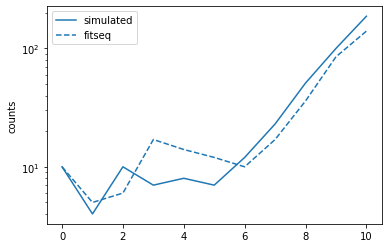

In [63]:
barcode = sorted_index[1]
ax = simulated_cell_counts[barcode].plot(label="simulated")
ax = estimated_cell_counts[barcode].plot(ax=ax, logy=True, color=ax.lines[0].get_color(), style='--', label="fitseq")
ax.legend()
ax.set_ylabel("counts")

In [48]:
sliding_counts = dict([(k,v.loc[1:,"Estimated_Read_Number_t0":]) for k,v in sliding_estimates.items()])
#ax = simulated_cell_counts.mean(axis='columns').plot(ax=ax, logy=True)

Text(0, 0.5, 'counts')

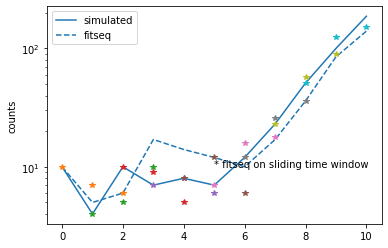

In [49]:
fig, ax = pyplot.subplots()


simulated_cell_counts[barcode].plot(ax=ax, label="simulated")
estimated_cell_counts[barcode].plot(ax=ax, logy=True, label="fitseq", color='tab:blue', style="--")

for k,v in sliding_counts.items():
    t0, t2 = [int(token) for token in k.split('-')]
    t1 = (t2+t0)/2
    
    reads = v.loc[barcode]
    reads.index = (t0, t1, t2)
    
    reads.plot(ax=ax, logy=True, style="*", label="")



ax.text(5,10,"* fitseq on sliding time window")
ax.legend()
ax.set_ylabel("counts")

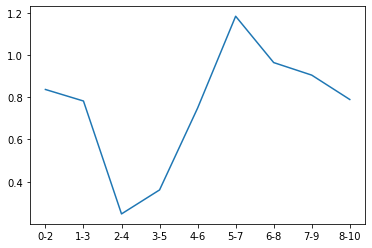

In [50]:
fig,ax = pyplot.subplots()
ax.plot(sliding_fitness.loc[barcode])

In [51]:
times = simulated_cell_counts.index.values; times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [52]:
m = simulated_cell_counts.mean(axis=1); m

0     10.00
1      3.26
2      3.03
3      2.99
4      3.42
5      3.44
6      3.45
7      3.64
8      4.46
9      6.02
10     6.54
dtype: float64

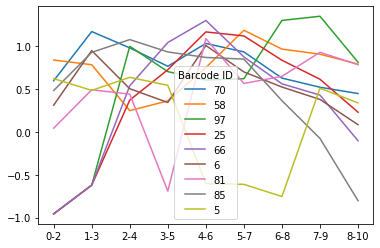

In [53]:
sliding_fitness.loc[sorted_index[:9]].T.plot()

### Analyse time dependence of competition matrix 

In [68]:
list(runs[0].keys())

[0.0,
 10.00069031402794,
 1.0002435940201806,
 2.0074292610301923,
 3.0134382574840717,
 4.016205292027175,
 5.03134917065716,
 6.04065159533337,
 7.041313014787152,
 8.047927775133175,
 9.05725352858651]

In [54]:
CM = [reduced_competition_matrix(snap) for snap in runs[0].values()]

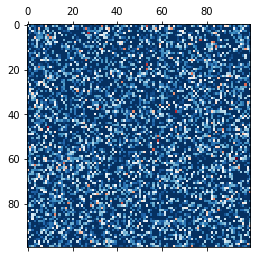

In [55]:
pyplot.matshow(CM[0], cmap='RdBu_r')

In [56]:
CV = numpy.array([cm.sum(axis=0) for cm in CM]).T[sorted_index[:9]]

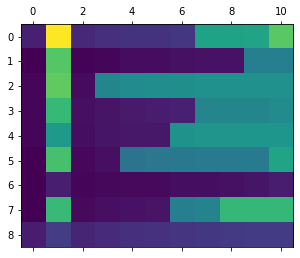

In [57]:
pyplot.matshow(CV)

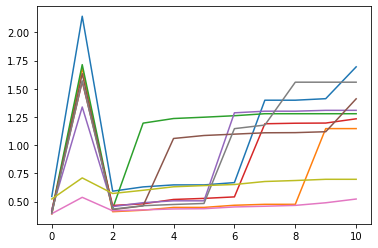

In [58]:
fig, ax = pyplot.subplots()
for i,cv in enumerate(CV):
    ax.plot(cv)
    

Text(0, 0.5, 'Wright fitness')

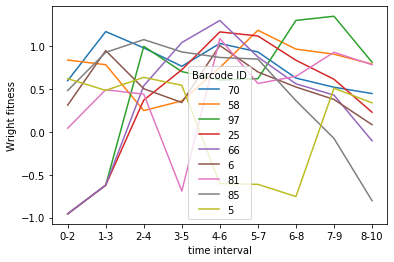

In [59]:
fig, ax = pyplot.subplots()
sliding_fitness.loc[sorted_index[:9]].T.plot(ax=ax)
ax.set_xlabel("time interval")
ax.set_ylabel("Wright fitness")


## Effective fitness coeff

Consider the Lotka-Volterra model formulated in the Gause notation of 
The effective fitness is given by $r_{eff} = r(1-\bar\alpha_i)$ with the effective competitiveness of species $i$, $\bar\alpha_i = \frac{\sum_j \alpha_{ij}N_j}{\sum_j N_j}$ 

In [60]:
# birth and death rates and carrying capacity
d = death_rate(runs[0])

In [61]:
d[d.isna()] = 0

In [62]:
d

Barcode ID         0  1  2  3  4  5  6  7  8  9   ... 70    97 58 25 58 70     \
Mutant ID          0  0  0  0  0  0  0  0  0  0   ... 23 24 25 26 27 28 29 30   
time (generations)                                ...                           
0.000000            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
1.001076            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
2.002256            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
3.003929            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
4.003993            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
5.005867            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
6.007463            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
7.011218            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
8.013719            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
9.014079            0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   
10.000044           0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0   

Barcode ID         97 6   
Mutant ID          31 32  
time (generations)        
0.000000            0  0  
1.001076            0  0  
2.002256            0  0  
3.003929            0  0  
4.003993            0  0  
5.005867            0  0  
6.007463            0  0  
7.011218            0  0  
8.013719            0  0  
9.014079            0  0  
10.000044           0  0  

[11 rows x 132 columns]

In [63]:
b = division_rate(runs[0])

In [64]:
b[b.isna()] = 1

In [65]:
reff = [1.- CM[t].dot(simulated_cell_counts.loc[t]) / simulated_cell_counts.loc[t].sum() for t in times]

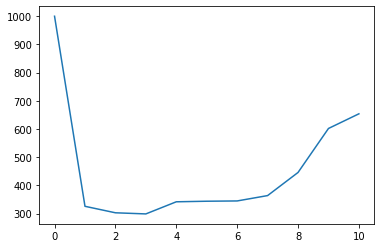

In [66]:
fig, ax = pyplot.subplots()
ax.plot(simulated_cell_counts.sum(axis=1))

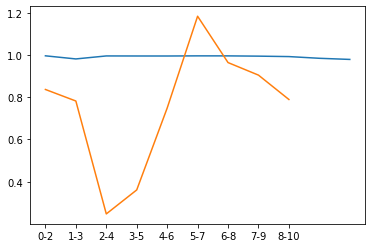

In [67]:
fig, ax = pyplot.subplots()
ax.plot([r[barcode] for r in reff])
ax.plot(sliding_fitness.loc[barcode])

not quite !!!

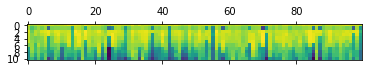

In [68]:
fig, ax = pyplot.subplots()
ax.matshow(reff)